# Carga del dataset

In [1]:
from sklearn.datasets import fetch_openml,load_digits

In [2]:
# mnist = fetch_openml('mnist_784', version=1) # Si no lo hemos descargado
mnist = load_digits() # Si ya lo tenemos descargado

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X,y = mnist['data'],mnist['target']
X.shape,y.shape

((70000, 784), (70000,))

Las imágenes están cargadas como vectores de 784 componentes, c/u con un nro entre 0 y 255. Haciendo `reshape`,podemos visualizar la imagen en `matplotlib`:

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
first_digit = X.to_numpy()[0]
image = first_digit.reshape(28,28)

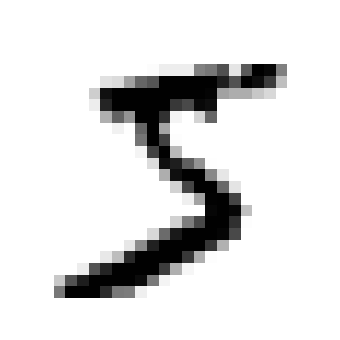

In [7]:
plt.figure(figsize=(8,6))
plt.imshow(image,cmap='binary')
plt.axis('off')
plt.show()

In [8]:
y[0]

'5'

## Training set, Test Set
El dataset de MNIST ya está dividido en un training set con las primeras 60000 imágenes y un test set de 10000. Ya está bien mezclado, y tenemos garantizado que todos los folds para validación cruzada van a ser similares.

In [9]:
X_train, X_test = X.to_numpy()[:60000], X.to_numpy()[60000:]
y_train, y_test = y.to_numpy()[:60000], y.to_numpy()[60000:]

# Entrenar un clasificador binario
El libro propone que simplifiquemos el problema por ahora y que intentemos construir un clasificador binario, por ejemplo para el nro. 5. Este debería distinguir entre los nros. que son 5 y los que no. 

In [10]:
# Creación de los targets
y_train_5 = (y_train=='5')
y_test_5 = (y_test=='5')

Un buen clasificador con el que comenzar es el `SGD` (Stochastic Gradient Descent).

Continuamos con lo que veníamos haciendo en el primer notebook, sólo que seguimos acá para que no demore tanto en cargar el notebook...
# Clasificación Multilabel
En algunos casos vamos a querer que el clasificador saque en output multiples clases para cada instancia. Un clasificador de ese tipo con múltiples tags es un _multilabel classification system_.

In [9]:
# Carga de los datos notebook anterior
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1) # Si no lo hemos descargado

X,y = mnist['data'],mnist['target']
X_train, X_test = X.to_numpy()[:60000], X.to_numpy()[60000:]
y_train, y_test = y.to_numpy()[:60000].astype(int), y.to_numpy()[60000:].astype(int)

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

In [12]:
sgd = SGDClassifier(random_state=42)

sgd.fit(X_train,y_train_5)

SGDClassifier(random_state=42)

In [13]:
# Lo podemos usar para detectar imágenes con el nro. 5
sgd.predict([first_digit])

array([ True])

## Medición de performance

In [13]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large,y_train_odd]

In [19]:
# Entrenamos KNN
knn = KNeighborsClassifier(n_jobs=5)
knn.fit(X_train,y_multilabel)

KNeighborsClassifier(n_jobs=5)

In [20]:
knn.predict([X_train[0]])

array([[False,  True]])

El dígito 5 no es _grande_ y es impar. Bien!

Un approach para evaluar al clasificador es calcular el F1 score para cada label, y después devolver el score promedio:

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score

In [15]:
cross_val_score(sgd,X_train,y_train_5,n_jobs=4,cv=4,scoring='accuracy')

array([0.95766667, 0.9664    , 0.96513333, 0.95366667])

Hay un ejemplo del libro (no hace falta desarrollarlo) en el que se argumenta que si el clasificador simplemente etiquetara a todas las imágenes como no 5, aún así estaríamos obteniendo una precisión del 90%. Entonces en casos como estos, la precisión no es una buena medida de performance para los clasificadores.

### Matriz de confusión
Una mejor manera de medir la performance es ir a mirar la matriz de confusión. Su idea general es contar las veces que las instancias de la clase A son clasificadas en la clase B.

Utilicemos `cross_val_predict()`. Esta función es una validación cruzada que devuelve las predicciones hechas en cada fold. 

In [16]:
from sklearn.model_selection import cross_val_predict

In [17]:
y_train_pred = cross_val_predict(sgd,X_train,y_train_5,cv=4,n_jobs=4)

In [18]:
from sklearn.metrics import confusion_matrix

In [19]:
confusion_matrix(y_train_5,y_train_pred)

array([[53263,  1316],
       [ 1041,  4380]])

En la diagonal están los elementos predichos correctamente, mientras que tenemos 1316 falsos positivos, y 1041 falsos negativos. 

Otras métricas que se suelen considerar en este tipo de problemas son la precisión (distinta de `accuracy`, esta es `precision`), el `recall` (sensibilidad):

$$\operatorname{precision} = \frac{TP}{TP+FP}\\$$
$$\operatorname{recall} = \frac{TP}{TP+FN}$$


¿Cómo se interpretan estos valores?
- La precisión indica que cuando el detector indica que la imagen es un 5, esto será cierto el 76.9% de las veces. 
- Además, sólo detecta el 80.8% de los 5s.

A menudo es conveniente combinar precisión y recall en una misma métrica llamada el `F1-score`, que representa el armónico medio, dando más importancia a los valores más pequeños.

$$F_1 = \frac{2}{\frac{1}{\operatorname{precision}}+\frac{1}{\operatorname{recall}}}$$

In [20]:
from sklearn.metrics import precision_score,recall_score,f1_score

In [21]:
print('Precision =',precision_score(y_train_5,y_train_pred))
print('Recall =',recall_score(y_train_5,y_train_pred))
print('F1 =',f1_score(y_train_5,y_train_pred))

Precision = 0.7689606741573034
Recall = 0.8079690094078583
F1 = 0.7879823693442477


En algunos contextos, vamos a estar más preocupados por la precisión y otras por el recall Ejemplo: si queremos un clasificador que detecte videos que son seguros para los niños, es preferible un clasificador que sea muy preciso, pero quizá no sea tan importante descartar algunos videos buenos. Por el otro lado, quizá para detectar ladrones en cámaras de vigilancia, sea mejor un clasificador que de falsos positivos, siempre que podamos atrapar a (casi) todos los ladrones.

Los dos no pueden tenerse a la vez; incrementar la precisión reduce el recall y viceversa. Esto se le llama _precision/recall trade-off_. Esto es por como funciona el `SGDClassifier`, que clasifica según si el `score` de la imagen es mayor-menor a un cierto threshold. Este threshold no puede ser fijado por el usuario, pero si nos deja ver los scores de cada una de las predicciones.

¿Podemos elegir que threshold usar? Hay que empezar por pedirle a `cross_val_predict()`que nos devuelva los `decision_scores` en vez de las predicciones:

In [22]:
y_scores = cross_val_predict(sgd,X_train,y_train_5,cv=4,
                             method='decision_function',n_jobs=4,
                            verbose=1)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   10.7s remaining:   10.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   12.0s finished


Con esos datos, podemos computar `precision_recall_curve()` para obtener precisión y recall para todos los posibles thresholds:

In [23]:
from sklearn.metrics import precision_recall_curve

In [24]:
precision,recall,thresh = precision_recall_curve(y_train_5,y_scores)

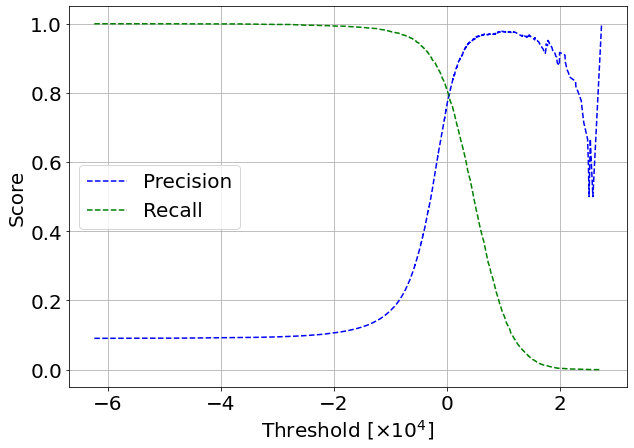

In [25]:
plt.figure(figsize=(10,7))

plt.plot(thresh/10000,precision[:-1],'b--',label='Precision')
plt.plot(thresh/10000,recall[:-1],'g--',label='Recall')

plt.xlabel('Threshold $[\\times 10^4]$',size=20);plt.ylabel('Score',size=20)
plt.xticks(size=20);plt.yticks(size=20)
plt.legend(fontsize=20)
plt.grid()
plt.show()

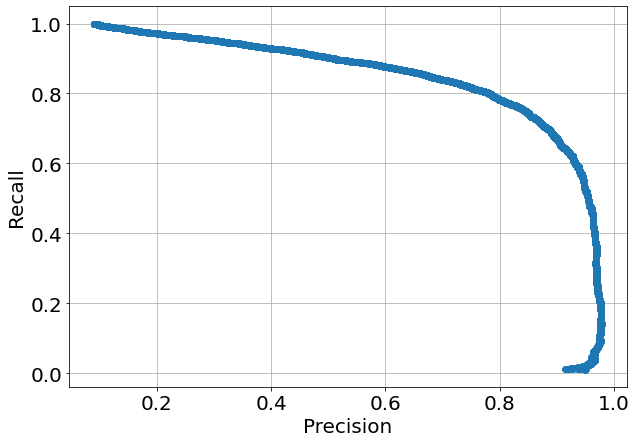

In [26]:
plt.figure(figsize=(10,7))

plt.plot(precision[:-60],recall[:-60],'o--')

plt.xlabel('Precision',size=20);plt.ylabel('Recall',size=20)
plt.xticks(size=20);plt.yticks(size=20)
plt.grid()
plt.show()

Supongamos que queremos un 90% de precisión. Entonces podemos buscar ese threshold, y además podemos saber por anticipación cuál sería el recall de esa elección.

In [27]:
import numpy as np

In [28]:
thresh_90_prec = thresh[np.argmax(precision >= 0.90)]

# Usemos esto para ver el score en el training set
y_train_pred_90 = (y_scores >=thresh_90_prec)

print('Precision =',precision_score(y_train_5,y_train_pred_90))
print('Recall =',recall_score(y_train_5,y_train_pred_90))

Precision = 0.9000989119683481
Recall = 0.6714628297362111


### Curva ROC
La curva roc es similar a la de precision/recall, pero lo que calcula en cambio es el rate de verdaderos positivos (TPR) vs. el rate de falsos positivos (FPR).

In [29]:
from sklearn.metrics import roc_curve

In [30]:
fpr,tpr,thresh = roc_curve(y_train_5,y_scores)

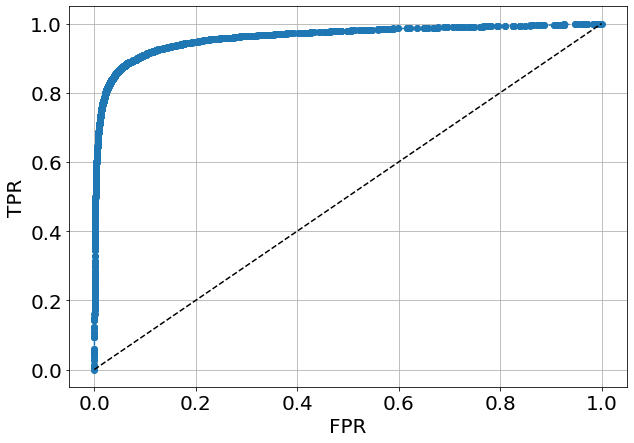

In [31]:
plt.figure(figsize=(10,7))

plt.plot(fpr,tpr,'o--')
plt.plot([0,1],[0,1],'k--')

plt.xlabel('FPR',size=20);plt.ylabel('TPR',size=20)
plt.xticks(size=20);plt.yticks(size=20)
plt.grid()
plt.show()

Una manera de comparar clasificadores es medir el área bajo esta curva. Un clasificador perfecto tendrá un ROC AUC de 1, mientras que un clasificador totalmente random tendrá un ROC AUC de 0.5 Scikit tiene una función para ello:

In [32]:
from sklearn.metrics import roc_auc_score

In [33]:
roc_auc_score(y_train_5,y_scores)

0.9614697242202009

Entrenemos un `RandomForestClassifier` y comparemos su curva ROC y su ROC AUC contra el SGD Classifier.

__Nota:__ `RandomForestClassifier`no tiene una función de decisión. En cambio, tiene un método `predict_proba()`.

In [34]:
from sklearn.ensemble import RandomForestClassifier

In [35]:
forest = RandomForestClassifier(random_state=42)
y_prob_forest = cross_val_predict(forest,X_train,y_train_5,
                                 cv=4,method='predict_proba',
                                 n_jobs=4,verbose=1)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   26.6s remaining:   26.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   27.4s finished


La función `roc_curve()` espera labels y scores, pero en vez de eso podemos pasarle las probabilidades de clase. Usemos como score la probabilidad de dar positivo.

In [36]:
y_scores_forest = y_prob_forest[:,1]

fpr_forest,tpr_forest,thresh_forest = roc_curve(y_train_5,y_scores_forest)

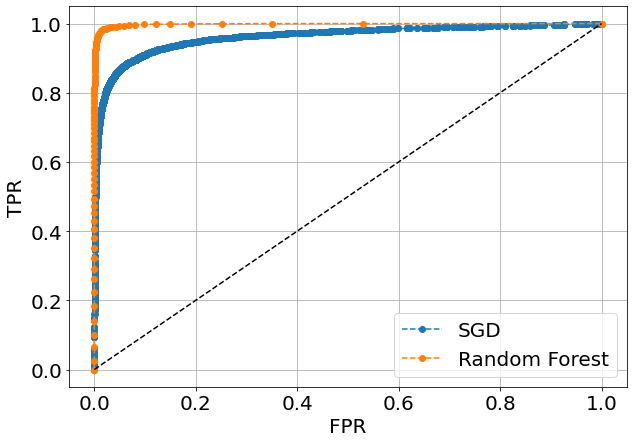

In [37]:
plt.figure(figsize=(10,7))

plt.plot(fpr,tpr,'o--',label='SGD')
plt.plot(fpr_forest,tpr_forest,'o--',label='Random Forest')

plt.plot([0,1],[0,1],'k--')

plt.xlabel('FPR',size=20);plt.ylabel('TPR',size=20)
plt.xticks(size=20);plt.yticks(size=20)
plt.legend(fontsize=20)
plt.grid()
plt.show()

El clasificador `RandomForest` hace una curva ROC bastante más cercana a la esquina superior izquierda del gráfico. Por lo tanto, su ROC AUC también será mucho mejor:

In [38]:
roc_auc_score(y_train_5,y_scores_forest)

0.9984268710591231

In [39]:
# Hay que convertir y_prob_forest a un array de bools
y_predict_forest = (y_prob_forest[:,1]>=y_prob_forest[:,0])

In [40]:
print('Precision RandomForest =',precision_score(y_train_5,
                                                 y_predict_forest))
print('Recall RandomForest =',recall_score(y_train_5,
                                          y_predict_forest))

Precision RandomForest = 0.9892361829848892
Recall RandomForest = 0.8815716657443277


# Clasificación Multiclase
Algunos algoritmos como los SGD, RandomForest,  naive Bayes,..., son capaces de menejar múltiples clases antivamente. Otros como la regresión logística o las Support Vector Machines son binarios. De todas formas, hay estrategias para realizar clasificación multiclase utilizando clasificadores binarios. 

Una manera es entranando 10 clasificadores binarios. Obtenemos el score de cada clasificador y luego elegimos la clase que sale con el más alto. Esta es una estrategia *OvR* (uno contra el resto).

Otra estrategia es entrenar un clasificador binario por cada par de dígitos: distinguit 0s de 1s, 0s de 2s, etc. Esta es la estrategia *OvO* (one vs. one). Si hay $N$ clases, hay que entrenar $N(N-1)/2$ clasificadores (45 para MNIST). La principal ventaja de este approach es que cada clasificador sólo necesita ser entranado en la parte del training set para las dos clases que debe distinguir. 

Algunos algoritmos no escalean bien con el tamaño del training set (como las Support Vector Machines). Esto hace que sea preferible elegir una estrategia OvO. Para la mayoría de los algoritmos de clasificación, se prefiere OvR.

Scikit elige esto automáticamente siempre que intentemos usar un algoritmo de clasificación binario, y automáticamente corre OvR u OvO, dependiendo del algoritmo. 

In [41]:
from sklearn.svm import SVC

In [42]:
svm = SVC()
svm.fit(X_train,y_train)
svm.predict([first_digit])

array(['5'], dtype=object)

Si llamamos al método `decision_function()`, vamos a ver que nos devuelve 10 scores por instancia.

In [43]:
first_digit_scores = svm.decision_function([first_digit])
print(first_digit_scores)

print(svm.classes_)

[[ 1.72501977  2.72809088  7.2510018   8.3076379  -0.31087254  9.3132482
   1.70975103  2.76765202  6.23049537  4.84771048]]
['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


Se puede forzar a Scikit a usar alguna estrategia definida, usando algunas clases. Se crea una instancia, y se pasa un clasificador al constructor. 

In [44]:
from sklearn.multiclass import OneVsOneClassifier

In [45]:
ovr_svm = OneVsOneClassifier(SVC())
ovr_svm.fit(X_train,y_train)
ovr_svm.predict([first_digit])
print(len(ovr_svm.estimators_))

45


Entrenar `SGDClassifier` o `RandomForestClassifier` es igual de sencillo.

In [46]:
sgd.fit(X_train,y_train)
sgd.predict([first_digit])

array(['3'], dtype='<U1')

In [47]:
forest.fit(X_train,y_train)
forest.predict([first_digit])

array(['5'], dtype=object)

Miremos el score del `SGDClassifier` para cada clase:

In [48]:
sgd.decision_function([first_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

Pareciera estar seguro de que es un 3, salvo una pequeña duda con 5.

Evaluemos la precisión mediante una validación cruzada.

In [49]:
cross_val_score(sgd,X_train,y_train,cv=4,scoring='accuracy',n_jobs=4)

array([0.85346667, 0.8756    , 0.86573333, 0.8816    ])

Todas las predicciones están por encima del 85%, no está mal.

Sin embargo, simplemente con escalear los inputs es posible incrementar aún más la precisión:

In [50]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

cross_val_score(sgd,X_train_scaled,y_train,cv=4,
                scoring='accuracy',n_jobs=4)

array([0.8988    , 0.8968    , 0.89106667, 0.9076    ])

# Análisis de Errores
Vamos a revisar la matriz de confusión. Tal como hicimos antes, llamamos a `confusion_matrix()`.

In [53]:
y_train_pred = cross_val_predict(sgd,X_train,y_train,n_jobs=3,cv=3,verbose=1)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.3min finished


In [54]:
conf_mx = confusion_matrix(y_train,y_train_pred)

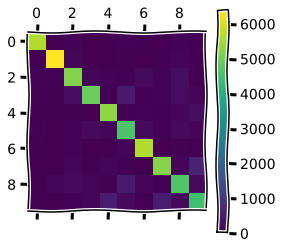

In [62]:
with plt.xkcd():
    plt.matshow(conf_mx);
    plt.colorbar();

Hagamos un ploteo de los errores.

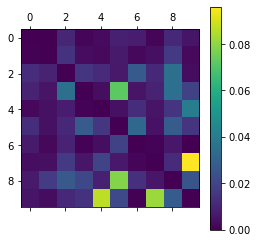

In [64]:
row_sums = conf_mx.sum(axis=1,keepdims=True)
norm_conf_mx = conf_mx/row_sums

# Llenamos la diagonal con ceros
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx)
plt.colorbar()
plt.show()

In [67]:
# Ejemplos de 3 y 5
cl_a,cl_b = '3','5'
X_aa = X_train[(y_train==cl_a) & (y_train_pred==cl_a)]
X_ab = X_train[(y_train==cl_a) & (y_train_pred==cl_b)]
X_ba = X_train[(y_train==cl_b) & (y_train_pred==cl_a)]
X_bb = X_train[(y_train==cl_b) & (y_train_pred==cl_b)]

In [83]:
# Código del libro para imprimir dígitos
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image,**options)
    plt.axis("off")

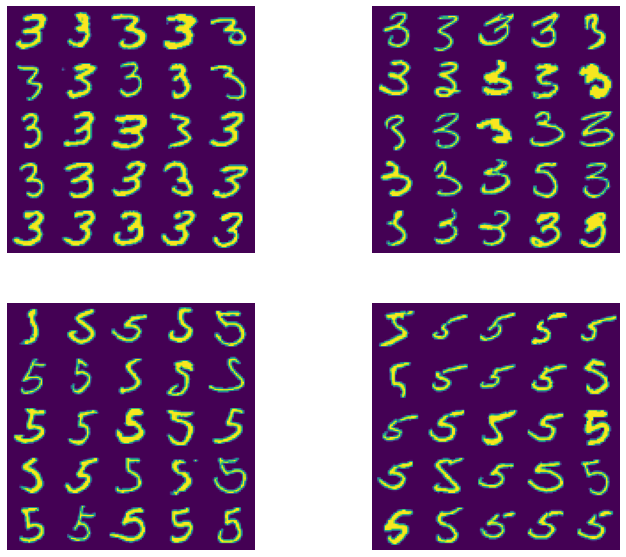

In [84]:
plt.figure(figsize=(12,10))

plt.subplot(221);plot_digits(X_aa[:25],images_per_row=5)
plt.subplot(222);plot_digits(X_ab[:25],images_per_row=5)
plt.subplot(223);plot_digits(X_ba[:25],images_per_row=5)
plt.subplot(224);plot_digits(X_bb[:25],images_per_row=5)
plt.show()

Hay algunos errores que parecen entendibles (quizá un humano también los hubiera cometido), aunque hay algunos que no. ¿Por qué el algoritmo se equivoca? La respuesta está en que SGD es un modelo lineal. 

<span style="color:red">**=======**</span>

In [22]:
y_train_knn_pred = cross_val_predict(knn,X_train,y_multilabel,cv=3,n_jobs=3)

f1_score(y_multilabel,y_train_knn_pred,average='macro')

0.976410265560605

Este promedio asume que todos los labels son igualmente importantes. Sin embargo, quizá deseemos pesarlo, por ejemplo si no tenemos la misma cantidad de instancias en el dataset para todos los labels. Para eso, seteamos `average=weighted` en el código anterior.
# Clasificación Multioutput
Simplemente una generalización de lo anterior, donde cada label puede ser multiclase (el anterior eran varios labels, todos binarios).
Vamos a agregar un poco de ruido en las imágenes con `randint`. Los targets van a ser entonces las imágenes originales (una especie de filtro para fotos!)

In [23]:
noise = np.random.randint(0,100,(len(X_train),784))
X_train_mod = X_train + noise

noise = np.random.randint(0,100,(len(X_test),784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

Text(0.5, 1.0, 'Original image')

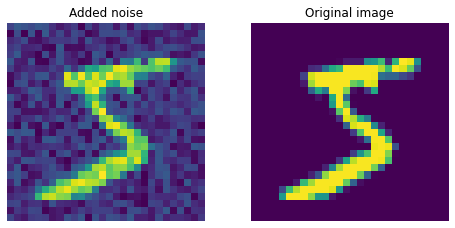

In [28]:
plt.figure(figsize=(8,8))
plt.subplot(221);plt.imshow(X_train_mod[0].reshape(28,28))
plt.axis('off');
plt.title('Added noise')
plt.subplot(222);plt.imshow(y_train_mod[0].reshape(28,28))
plt.axis('off');
plt.title('Original image');

In [42]:
knn.fit(X_train_mod,y_train_mod)

KNeighborsClassifier(n_jobs=5)

In [43]:
clean_digit = knn.predict([X_test_mod[0]])

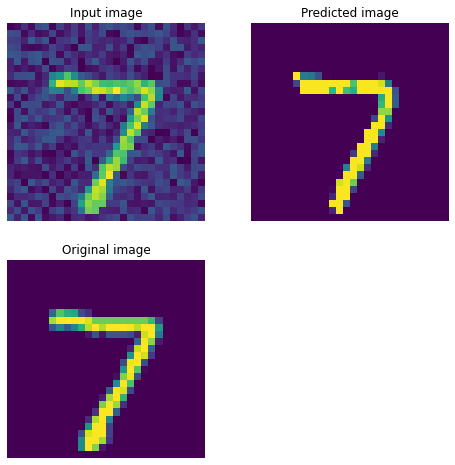

In [44]:
plt.figure(figsize=(8,8))
plt.subplot(221);plt.imshow(X_test_mod[0].reshape(28,28))
plt.axis('off');
plt.title('Input image')
plt.subplot(222);plt.imshow(clean_digit.reshape(28,28))
plt.axis('off');
plt.title('Predicted image');
plt.subplot(223);plt.imshow(y_test_mod[0].reshape(28,28))
plt.axis('off')
plt.title('Original image');